## Notebook description

Paper figure 3 - air-sea flux

In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script> so much code! click <a href="javascript:code_toggle()">here</a>.''')

In [4]:
import numpy as np
# import xarray as xr
import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
# from mpl_toolkits.basemap import Basemap
# from scipy.io import loadmat
from cmocean import cm
import pandas as pd
import warnings
import pickle
import arrow
#from cartopy import crs, feature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from salishsea_tools import viz_tools
import netCDF4 as nc

#import LambertConformalTicks as lct

%matplotlib inline
plt.rcParams['font.size'] = 11
warnings.simplefilter('ignore')

## Load flux calculations and convert from mmol/m2/s to mmol/day and g/yr

In [5]:
BR_flx = pickle.load(open('../pkls/flux/BR3_flx.pkl', 'rb')) * 1.11 #asselin filter
BR_flx[BR_flx>1e5]=np.nan

#mmol/m2/s > mmol/m2/day
BR_flx_mmol_m2_day = BR_flx * 86400
BR_daily_mean_mmol_m2_day = np.zeros(365)

for i in range(0,365):
    BR_daily_mean_mmol_m2_day[i] = np.nanmean(BR_flx_mmol_m2_day[i,:,:])

BR_flx_mmol_m2_yr = np.sum(BR_flx_mmol_m2_day, axis = 0)
#mmol/yr to g/yr 12.0107 g/mol /1000 for mmol
BR_flx_gC_m2_yr = BR_flx_mmol_m2_yr*12.0107*1e-3
BR_flx_gC_m2_yr[BR_flx_gC_m2_yr>1e6]=np.nan
BR_flx_gC_m2_yr[BR_flx_gC_m2_yr==0]=np.nan
print('mean BR flux g/m2/yr')
print(np.nanmean(BR_flx_gC_m2_yr))

PI_flx = pickle.load(open('../pkls/flux/PI5_flx.pkl', 'rb')) * 1.11 #asselin filter
PI_flx[PI_flx>1e4]=np.nan
PI_flx[PI_flx<-1e4]=np.nan

#mmol/m2/s > mmol/m2/day
PI_flx_mmol_m2_day = PI_flx * 86400
PI_daily_mean_mmol_m2_day = np.zeros(365)

for i in range(0,365):
    PI_daily_mean_mmol_m2_day[i] = np.nanmean(PI_flx_mmol_m2_day[i,:,:])

PI_flx_mmol_m2_yr = np.sum(PI_flx_mmol_m2_day, axis = 0)
#mmol/yr to g/yr 12.0107 g/mol /1000 for mmol
PI_flx_gC_m2_yr = PI_flx_mmol_m2_yr*12.0107*1e-3
PI_flx_gC_m2_yr[PI_flx_gC_m2_yr>1e6]=np.nan
PI_flx_gC_m2_yr[PI_flx_gC_m2_yr==0]=np.nan
print('mean PI flux g/m2/yr')
print(np.nanmean(PI_flx_gC_m2_yr))

mean BR flux g/m2/yr
-8.199290057761285
mean PI flux g/m2/yr
-6.048057726577019


In [6]:
tsal = pickle.load(open('../pkls/BR3_sal_summer_mean.pkl', 'rb'))
print(np.shape(tsal))
surfsal = tsal[0,:,:]
print(np.size(tsal == 0))
lmask = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
tmask = (lmask['tmask'][0,0,:,:])
w = np.where((surfsal < 2) & (tmask == 1))
print(np.size(w))
print(np.nanmean(BR_flx_gC_m2_yr[w]))

(40, 898, 398)
14296160
1818
-66.28897879825332


## calculate mean pco2 for PI5 run and BR3 run

In [7]:
start ='2015-01-01'
end ='2015-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array1 = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array1.append(r)
dayslen = len(arrow_array1)

pco2_daily_mean_BR3 = np.zeros(dayslen)
pco2_daily_mean_PI5 = np.zeros(dayslen)
wind_daily_mean = np.zeros(dayslen)

for i in range(0,dayslen):

    tdate = arrow_array1[i][0]
    ymd = tdate.format('YYYYMMDD')

    if i%100 == 0:
        print(ymd)
    t_pco2 = nc.Dataset('//data/tjarniko/results/BASERUN_EXP/Oma_calc/BR3_OmA_plus_'+ymd+'.nc')
    pco2 = t_pco2['model_output']['pCO2'][:]
    pco2[pco2>1e4]= np.nan
    pco2_daily_mean_BR3[i] = np.nanmean(pco2)

    t_pco2 = nc.Dataset('//data/tjarniko/results/BASERUN_EXP/Oma_calc/PI5_OmA_plus_'+ymd+'.nc')
    pco2 = t_pco2['model_output']['pCO2'][:]
    pco2[pco2>1e4]= np.nan
    pco2_daily_mean_PI5[i] = np.nanmean(pco2)
    #wind
    t_wind = nc.Dataset('//data/tjarniko/results/hindcast.201905_windmag_interp/windmag_interp_1d_'+ymd+'.nc')
    wind = t_wind['model_output']['wind_mag'][:]
    wind[wind>1e4]= np.nan
    wind_daily_mean[i] = np.nanmean(wind)

20150101
20150411
20150720
20151028


#### get mean over-water windspeed squared

In [8]:
#brute force mask for wsquared
bathy = nc.Dataset('/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
landmask = (np.where(np.ma.is_masked(bathy['Bathymetry'][:])))
tbath = bathy['Bathymetry'][:]
w = np.zeros([898,398])


for i in range(0,898):
    for j in range(0,398):
        if np.ma.is_masked(tbath[i,j]):
            w[i,j] = np.nan

#calculate square of windspeed
start ='2015-01-01'
end ='2015-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array1 = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array1.append(r)
dayslen = len(arrow_array1)

wind_daily_mean_squared = np.zeros(dayslen)

for i in range(0,dayslen):

    tdate = arrow_array1[i][0]
    ymd = tdate.format('YYYYMMDD')

    if i%100 == 0:
        print(ymd)

    #wind
    t_wind = nc.Dataset('//data/tjarniko/results/hindcast.201905_windmag_interp/windmag_interp_1d_'+ymd+'.nc')
    wind = t_wind['model_output']['wind_mag'][:]
    windsqrd = wind**2
    windsqrd[np.isnan(w)] = np.nan 
    wind_daily_mean_squared[i] = (np.nanmean(windsqrd))

    

20150101
20150411
20150720
20151028


#### extract the atmospheric seasonal cycle for BR and PI

In [9]:
start ='2015-01-01'
end ='2015-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array.append(r)

dayslen = len(arrow_array)
atcco2_array = np.zeros(dayslen)
dec_time_array = np.zeros(dayslen)


#constants from SKOG for BR run

LR_slope   =  2.149     #  linear regression + gaussian fit
LR_int     =  -3929.359 #  to seasonal cycle of atmospheric co2
ctr        =  161.898   #  based on scripps observations at ptbarrow and lajolla
amp        =  7.083     #  calc notebook by TJSJ
wid        =  44.703    #  notebook loc:
ctr2       =  218.832   #  carbon_dev/MOCSY_and_FLUX/CO2_obs.ipynb
amp2       =  -19.004   #
wid2       =  87.8836   #
ctr3       =  199.430   #
amp3       =  8.026     #
wid3       =  -185.920  #

zz_LRslop = LR_slope
zz_LRint = LR_int
zz_ctr = ctr
zz_ctr2 = ctr2
zz_ctr3 = ctr3
zz_wid = wid
zz_wid2 = wid2
zz_wid3 = wid3
zz_amp = amp
zz_amp2 = amp2
zz_amp3 = amp3

for i in range(0,len(arrow_array)):

    tdate = arrow_array[i][0]
    ymd = tdate.format('YYYYMMDD')
    doy = tdate.format('DDDD')
    yr = tdate.format('YYYY')
    
    zz_year = int(yr)
    zz_day = int(doy)

    zz_yearcyc =  zz_amp * np.exp( -((zz_day - zz_ctr)/zz_wid)**2)\
      + zz_amp2 * np.exp( -((zz_day - zz_ctr2)/zz_wid2)**2)\
      + zz_amp3 * np.exp( -((zz_day - zz_ctr3)/zz_wid3)**2)

    zz_atcco2 = (zz_year+(zz_day/365))*zz_LRslop+zz_LRint + zz_yearcyc
    atcco2_array[i] = zz_atcco2
    dec_time_array[i] = zz_year+(zz_day/365)

LR_slope   =  0     #!  linear regression + gaussian fit
LR_int     =  280 #!  to seasonal cycle of atmospheric co2
ctr        =  161.898  # !  based on scripps observations at ptbarrow and lajolla
amp        =  7.083  # !  calc notebook by TJSJ
wid        =  44.703  #  !  notebook loc:
ctr2       =  218.832  # !  carbon_dev/MOCSY_and_FLUX/CO2_obs.ipynb
amp2       =  -19.004   #!
wid2       =  87.8836   #!
ctr3       =  199.430   #!
amp3       =  8.026     #!
wid3       =  -185.920  #!
    

zz_LRslop = LR_slope
zz_LRint = LR_int
zz_ctr = ctr
zz_ctr2 = ctr2
zz_ctr3 = ctr3
zz_wid = wid
zz_wid2 = wid2
zz_wid3 = wid3
zz_amp = amp
zz_amp2 = amp2
zz_amp3 = amp3

atcco2_array_PI = np.zeros(365)

for i in range(0,len(arrow_array)):

    tdate = arrow_array[i][0]
    ymd = tdate.format('YYYYMMDD')
    doy = tdate.format('DDDD')
    yr = tdate.format('YYYY')
    
    zz_year = int(yr)
    zz_day = int(doy)

    zz_yearcyc =  zz_amp * np.exp( -((zz_day - zz_ctr)/zz_wid)**2)\
      + zz_amp2 * np.exp( -((zz_day - zz_ctr2)/zz_wid2)**2)\
      + zz_amp3 * np.exp( -((zz_day - zz_ctr3)/zz_wid3)**2)

    zz_atcco2 = (zz_year+(zz_day/365))*zz_LRslop+zz_LRint + zz_yearcyc
    atcco2_array_PI[i] = zz_atcco2
    dec_time_array[i] = zz_year+(zz_day/365)



Text(0, 0.5, 'uatm pco2')

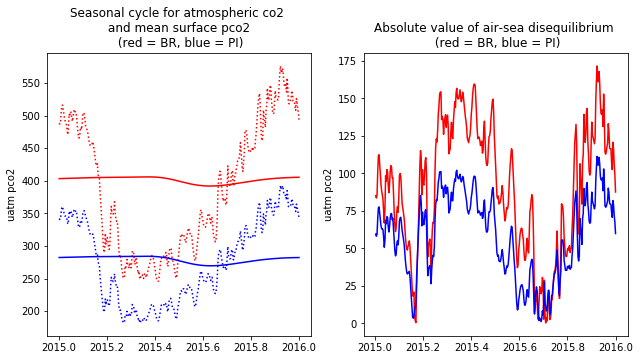

In [10]:
fact = 0.52
fig = plt.figure(figsize=(20*fact,10*fact))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(dec_time_array,atcco2_array, 'r-')
ax1.plot(dec_time_array,pco2_daily_mean_BR3, 'r:')
ax1.plot(dec_time_array,atcco2_array_PI, 'b-')
ax1.plot(dec_time_array,pco2_daily_mean_PI5, 'b:')
ax1.set_title('Seasonal cycle for atmospheric co2 \n and mean surface pco2 \n (red = BR, blue = PI)')
ax1.set_ylabel('uatm pco2')

diseq_BR3 = np.abs(atcco2_array-pco2_daily_mean_BR3)
diseq_PI5 = np.abs(atcco2_array_PI-pco2_daily_mean_PI5)
ax1 = fig.add_subplot(1,2,2)
ax1.plot(dec_time_array,diseq_BR3, 'r-')
ax1.plot(dec_time_array,diseq_PI5, 'b-')

ax1.set_title('Absolute value of air-sea disequilibrium \n (red = BR, blue = PI)')
ax1.set_ylabel('uatm pco2')

#### PLOT A: AIR-SEA FLUX TIMESERIES

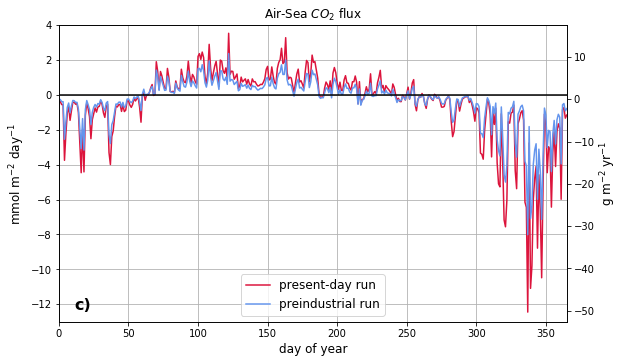

In [11]:
def plot_a(ax, fs):
    days = np.arange(1,366,1)
    ax.plot(days,BR_daily_mean_mmol_m2_day,color = 'crimson',label = 'present-day run')
    #ax1.plot(days,LA_daily_mean_mmol_m2_day,color = 'slategrey',label = 'LA run')
    ax.plot(days,PI_daily_mean_mmol_m2_day,color = 'cornflowerblue',label = 'preindustrial run')
    ax.set_xlabel('day of year',fontsize = fs)
    ax.set_ylabel('mmol m$^{-2}$ day$^{-1}$', fontsize = fs)
    ax.set_title('Air-Sea $CO_2$ flux', fontsize = fs)
    ax.grid()
    ax.legend(loc = 'lower center', fontsize = fs)
    ax.axhline(y=0, color = 'k')
    ax.text(0.03, 0.03, 'c)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='bottom')
    ax.set_ylim(-13.01,4.01)
    
    #conv factor mmol/m2/day to g/m2/yr
    cf = 12.0107e-3 * 365
    axb =ax.twinx()
    axb.set_ylim(-12.01*cf,4.01*cf)
    axb.set_ylabel('g m$^{-2}$ yr$^{-1}$', fontsize = fs)
    ax.set_xlim(0,365)
    axb.set_xlim(0,365)
    
fig = plt.figure(figsize=(17.5*fact, 10.5*fact))
ax1 = plt.subplot2grid((1,3), (0,0), colspan=3, rowspan=1) # topleft

plot_a(ax1,12)

#### PLOT B: WIND SPEED SQUARED AND DISEQUILIBRIUM

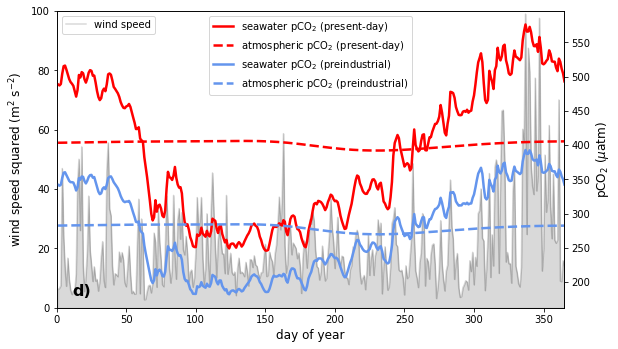

In [12]:
def plot_b(ax, fs):
    lw = 2.5
    alph = 0.15
    days = np.arange(1,366,1)
    #windspeed
    ax.plot(days,wind_daily_mean_squared,'-k', alpha = alph, label = 'wind speed')
    ax.fill_between(days, np.zeros_like(wind_daily_mean_squared), (wind_daily_mean_squared), \
                 color = 'k', alpha = alph )
    ax.set_ylim([0,100])
    ax.set_xlim([0,365])
    ax.set_ylabel('wind speed squared (m$^2$ s$^{-2}$)', fontsize = fs)
    axb =ax.twinx()
    axb.plot(days,pco2_daily_mean_BR3,'-r', linewidth = lw, label = 'seawater pCO$_2$ (present-day)')
    axb.plot(days,atcco2_array,color = 'r', linewidth = lw, linestyle = '--', label = 'atmospheric pCO$_2$ (present-day)' )

    axb.plot(days,pco2_daily_mean_PI5, color = 'cornflowerblue', linewidth = lw, linestyle = '-', label = 'seawater pCO$_2$ (preindustrial)')
    axb.plot(days,atcco2_array_PI,color = 'cornflowerblue', linestyle = '--', linewidth = lw, label = 'atmospheric pCO$_2$ (preindustrial)' )

    axb.legend(loc = 'best')
    axb.set_ylabel('pCO$_2#$ ($\mu$atm)', fontsize = fs)
    ax.set_xlabel('day of year', fontsize = fs)
    
    # axb.axhline(y=409, color = 'r', linestyle = ':')

    axb.set_xlim([0,365])
    ax.text(0.03, 0.03, 'd)', transform=ax.transAxes, fontsize=16, fontweight='bold', va='bottom')
    ax.legend(loc = 'best')
    #ax.grid()
    
fig = plt.figure(figsize=(17.5*fact, 10.5*fact))
ax1 = plt.subplot2grid((1,3), (0,0), colspan=3, rowspan=1) # topleft

plot_b(ax1,12)

#### PLOT C-E: Maps! (no function here, eventually a colorbar will have to be shared, which is 100% a project for mr. illustrator.

Text(0.03, 0.03, 'e)')

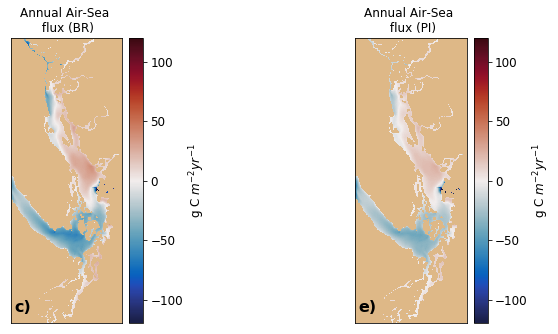

In [13]:
fs = 12
fact = 0.5
fig = plt.figure(figsize=(17.5*fact, 10.5*fact)) 

ax3 = plt.subplot2grid((1,3), (0,0), colspan=1,rowspan = 2)
tplt = BR_flx_gC_m2_yr
viz_tools.set_aspect(ax3)
mesh = ax3.pcolormesh(tplt, cmap=cm.balance, vmin=-120, vmax=120)
viz_tools.plot_land_mask(ax3, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax3.set_title('Annual Air-Sea \n flux (BR)', fontsize = fs)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label('g C $m^{-2}$$yr^{-1}$', fontsize = fs)
ax3.text(0.03, 0.03, 'c)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='bottom')



ax5 = plt.subplot2grid((1,3), (0,2), colspan=1,rowspan = 2)
tplt = PI_flx_gC_m2_yr
viz_tools.set_aspect(ax5)
mesh = ax5.pcolormesh(tplt, cmap=cm.balance, vmin=-120, vmax=120)
viz_tools.plot_land_mask(ax5, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax5.set_title('Annual Air-Sea \n flux (PI)', fontsize = fs)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label('g C $m^{-2}$$yr^{-1}$', fontsize = fs)
ax5.text(0.03, 0.03, 'e)', transform=ax5.transAxes, fontsize=16, fontweight='bold', va='bottom')




#### LOAD EVANS OBS. DATASET, CONVERT FROM MMOL/M2/DAY TO G/M2/YR

##### calculating annual mean - assumption that air-sea flux in spring is 0 

In [14]:
#to g m2 yr
cf = 12.0107e-3 * 365

data = pd.read_csv('../pkls/Evans_seaair_numbers.csv')
data = (-1)*data

NS_W_mean = (cf)*data['NSTRAIT_4'][0]; NS_W_std = (cf)*data['NSTRAIT_4'][1] ;
NS_W_min = (cf)*data['NSTRAIT_4'][2]; NS_W_max = (cf)*data['NSTRAIT_4'][3] ; 
NS_S_mean = (cf)*data['NSTRAIT_4'][4]; NS_S_std = (cf)*data['NSTRAIT_4'][5] ;
NS_S_min = (cf)*data['NSTRAIT_4'][6]; NS_S_max = (cf)*data['NSTRAIT_4'][7] ;
NS_A_mean = (cf)*data['NSTRAIT_4'][8]; NS_A_std = (cf)*data['NSTRAIT_4'][9] ;
NS_A_min = (cf)*data['NSTRAIT_4'][10]; NS_A_max = (cf)*data['NSTRAIT_4'][11] ;

CS_W_mean = (cf)*data['CSTRAIT_5'][0]; CS_W_std = (cf)*data['CSTRAIT_5'][1] ;
CS_W_min = (cf)*data['CSTRAIT_5'][2]; CS_W_max = (cf)*data['CSTRAIT_5'][3] ; 
CS_S_mean = (cf)*data['CSTRAIT_5'][4]; CS_S_std = (cf)*data['CSTRAIT_5'][5] ;
CS_S_min = (cf)*data['CSTRAIT_5'][6]; CS_S_max = (cf)*data['CSTRAIT_5'][7] ;
CS_A_mean = (cf)*data['CSTRAIT_5'][8]; CS_A_std = (cf)*data['CSTRAIT_5'][9] ;
CS_A_min = (cf)*data['CSTRAIT_5'][10]; CS_A_max = (cf)*data['CSTRAIT_5'][11] ;

JDF_W_mean = (cf)*data['JDF_6'][0]; JDF_W_std = (cf)*data['JDF_6'][1] ;
JDF_W_min = (cf)*data['JDF_6'][2]; JDF_W_max = (cf)*data['JDF_6'][3] ; 
JDF_S_mean = (cf)*data['JDF_6'][4]; JDF_S_std = (cf)*data['JDF_6'][5] ;
JDF_S_min = (cf)*data['JDF_6'][6]; JDF_S_max = (cf)*data['JDF_6'][7] ;
JDF_A_mean = (cf)*data['JDF_6'][8]; JDF_A_std = (cf)*data['JDF_6'][9] ;
JDF_A_min = (cf)*data['JDF_6'][10]; JDF_A_max = (cf)*data['JDF_6'][11] ;

#winter as January 1 to March 31, spring as April 1 to
#June 30, summer as July 1 to September 30, and autumn as October
#only calculating for JDF and CS , NS has no Winter data, which would be disingenuous
#1 to December 31.
D_SUM = 90
D_WINT = 90
D_AUT = 91

#calculating summer, winter, and autumn mean, with the assumption that a spring mean flux is 0 
JDF_ANN_MEAN = (D_SUM/365)*JDF_S_mean + (D_WINT/365)*JDF_W_mean + (D_AUT/365) * JDF_A_mean
CS_ANN_MEAN = (D_SUM/365)*CS_S_mean + (D_WINT/365)*CS_W_mean + (D_AUT/365) * CS_A_mean


# Evans_Mathis_2013 = 18

In [15]:
print(NS_S_mean)

-68.3889258


#### CALCULATE HISTOGRAM OF BR AND PI

In [16]:
BR_nonan = BR_flx_gC_m2_yr[~np.isnan(BR_flx_gC_m2_yr)]
PI_nonan = PI_flx_gC_m2_yr[~np.isnan(PI_flx_gC_m2_yr)]

step = 5
t_start = -100
t_end = 40
bin_starts = np.arange(t_start,t_end,step)
bin_ends = np.arange(t_start+step,t_end+step,step)
bin_centres = np.arange(t_start+step/2,t_end + step/2 ,step)
bin_prop = np.zeros_like(bin_centres)

def manual_hist(test_hist):
    for i in range(0,len(bin_starts)):
        obs_in_bin = test_hist[((test_hist>=bin_starts[i]) &\
                               (test_hist<bin_ends[i]))]

        bin_prop[i] = np.size(obs_in_bin)/np.size(test_hist)
    return bin_prop

# bin_propLA = manual_hist(LA_nonan)
# t_LA = np.copy(bin_propLA)
bin_propBR = manual_hist(BR_nonan)
t_BR = np.copy(bin_propBR)
bin_propPI = manual_hist(PI_nonan)   
t_PI = np.copy(bin_propPI)

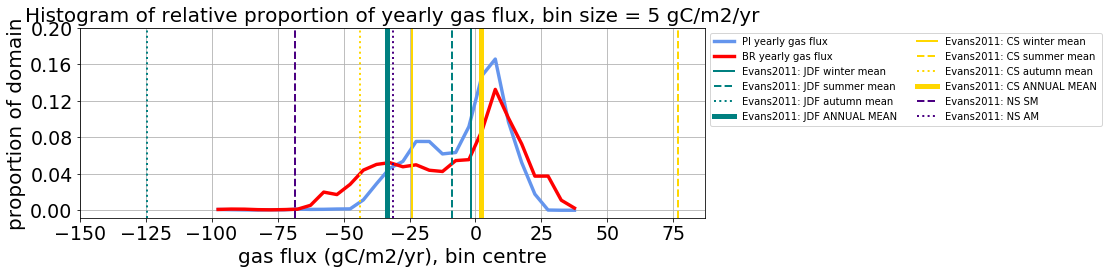

In [17]:
corfact = 1/(1 * (1/365) * (1 / 12.0107e-3))

fact = 0.7
fig = plt.figure(figsize=(16*fact,5*fact))
lw = 2.5
ax1 = fig.add_subplot(1,1,1)
#ax1.plot(bin_centres,t_LA, color = 'dimgrey', lw = 3.4, label = 'LA yearly gas flux')
ax1.plot(bin_centres,t_PI, color = 'cornflowerblue', lw = 3.4,label = 'PI yearly gas flux')
ax1.plot(bin_centres,t_BR, color = 'red', lw = 3.4,label = 'BR yearly gas flux')

ax1.axvline(JDF_W_mean, color = 'teal', lw = 2, label = 'Evans2011: JDF winter mean')
ax1.axvline(JDF_S_mean, color = 'teal', linestyle = '--' , lw = 2, label = 'Evans2011: JDF summer mean')
ax1.axvline(JDF_A_mean, color = 'teal', linestyle = ':', lw = 2, label = 'Evans2011: JDF autumn mean')
ax1.axvline(JDF_ANN_MEAN, color = 'teal', linestyle = '-', lw = 5, label = 'Evans2011: JDF ANNUAL MEAN')


ax1.axvline(CS_W_mean, color = 'gold', lw = 2, label = 'Evans2011: CS winter mean')
ax1.axvline(CS_S_mean, color = 'gold', linestyle = '--' , lw = 2, label = 'Evans2011: CS summer mean ')
ax1.axvline(CS_A_mean, color = 'gold', linestyle = ':', lw = 2, label = 'Evans2011: CS autumn mean')
ax1.axvline(CS_ANN_MEAN, color = 'gold', linestyle = '-', lw = 5, label = 'Evans2011: CS ANNUAL MEAN')

#ax1.axvline(NS_W_mean*corfact, color = 'indigo', lw = 2, label = 'NS winter mean')
ax1.axvline(NS_S_mean, color = 'indigo', linestyle = '--' , lw = 2, label = 'Evans2011: NS SM')
ax1.axvline(NS_A_mean, color = 'indigo', linestyle = ':', lw = 2, label = 'Evans2011: NS AM')

#
#ax1.axvline(88, color = 'lightsteelblue', lw = 2, label = 'Hales')
#ax1.axvline(-3.1, color = 'teal', lw = 2, label = '3)')
#ax1.axvline(7.9, color = 'crimson', lw = 2, label = '4)')
#ax1.axvline(26, color = 'lime', lw = 2, label = '1) BC coast')
#ax1.axvline(18, color = 'tan', lw = 2, label = 'Evans and Mathis 2013 Gulf of Alaska')

ax1.legend(bbox_to_anchor = [1,1],ncol=2)
ax1.set_title('Histogram of relative proportion of yearly gas flux, bin size = 5 gC/m2/yr', fontsize =20)

w = ax1.set_xticks(np.arange(-150, 100, step=25))
w = ax1.set_yticks(np.arange(0, 0.22, step=0.04))
ax1.set_xlabel('gas flux (gC/m2/yr), bin centre', fontsize =20 )
ax1.set_ylabel('proportion of domain', fontsize =20)
ax1.tick_params(axis='both', which='major', labelsize=19)
ax1.tick_params(axis='both', which='minor', labelsize=19)
ax1.grid()

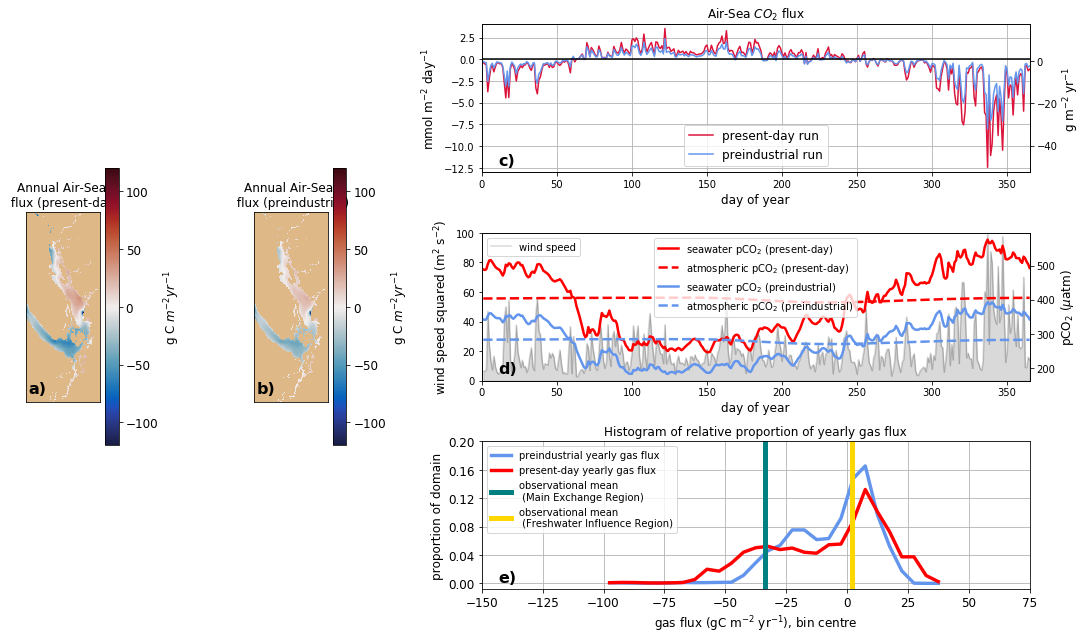

In [18]:
fact = 1
fig = plt.figure(figsize=(15*fact, 9*fact))

ax1 = plt.subplot2grid((3,5), (0,0), colspan=1, rowspan=3) # topleft
tplt = BR_flx_gC_m2_yr
viz_tools.set_aspect(ax1)
mesh = ax1.pcolormesh(tplt, cmap=cm.balance, vmin=-120, vmax=120)
viz_tools.plot_land_mask(ax1, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax1.set_title('Annual Air-Sea \n flux (present-day)', fontsize = fs)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label('g C $m^{-2}$$yr^{-1}$', fontsize = fs)
ax1.text(0.03, 0.03, 'a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='bottom')
ax1 = plt.subplot2grid((3,5), (0,1), colspan=1, rowspan=3) # topleft
tplt = PI_flx_gC_m2_yr
viz_tools.set_aspect(ax1)
mesh = ax1.pcolormesh(tplt, cmap=cm.balance, vmin=-120, vmax=120)
viz_tools.plot_land_mask(ax1, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax1.set_title('Annual Air-Sea \n flux (preindustrial)', fontsize = fs)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label('g C $m^{-2}$$yr^{-1}$', fontsize = fs)
ax1.text(0.03, 0.03, 'b)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='bottom')


ax1 = plt.subplot2grid((3,5), (0,2), colspan=3, rowspan=1) # topleft
plot_a(ax1,12)
ax1 = plt.subplot2grid((3,5), (1,2), colspan=3, rowspan=1) # topleft
plot_b(ax1,12)
ax1 = plt.subplot2grid((3,5), (2,2), colspan=3, rowspan=1) # topleft
corfact = 1/(1 * (1/365) * (1 / 12.0107e-3))

lw = 2.5
#ax1.plot(bin_centres,t_LA, color = 'dimgrey', lw = 3.4, label = 'LA yearly gas flux')
ax1.plot(bin_centres,t_PI, color = 'cornflowerblue', lw = 3.4,label = 'preindustrial yearly gas flux')
ax1.plot(bin_centres,t_BR, color = 'red', lw = 3.4,label = 'present-day yearly gas flux')

ax1.axvline(JDF_ANN_MEAN, color = 'teal', linestyle = '-', lw = 5, label = 'observational mean \n (Main Exchange Region)')

ax1.axvline(CS_ANN_MEAN, color = 'gold', linestyle = '-', lw = 5, label = 'observational mean \n (Freshwater Influence Region)')

ax1.legend(loc = 'best')
ax1.set_title('Histogram of relative proportion of yearly gas flux', fontsize =12)

w = ax1.set_xticks(np.arange(-150, 100, step=25))
w = ax1.set_yticks(np.arange(0, 0.22, step=0.04))
ax1.set_xlabel('gas flux (gC m$^{-2}$ yr$^{-1}$), bin centre', fontsize =12 )
ax1.set_ylabel('proportion of domain', fontsize =12)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='minor', labelsize=12)
ax1.grid()
ax1.text(0.03, 0.03, 'e)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='bottom')

plt.tight_layout()
plt.savefig('Fig3_c-e.png')

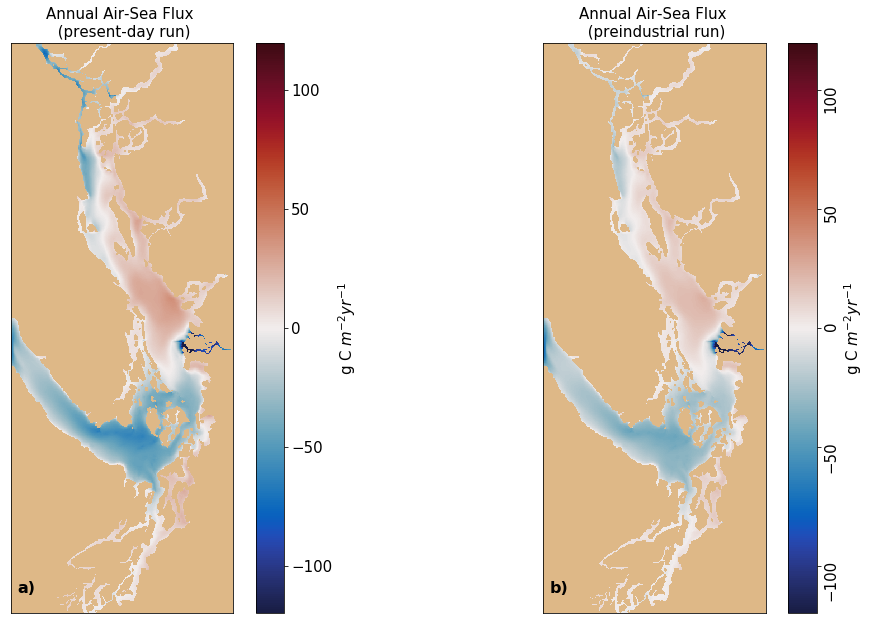

In [19]:
fs = 15
fact = 1
fig = plt.figure(figsize=(17.5*fact, 10.5*fact)) 

ax3 = plt.subplot2grid((1,2), (0,0), colspan=1,rowspan = 2)
tplt = BR_flx_gC_m2_yr
viz_tools.set_aspect(ax3)
mesh = ax3.pcolormesh(tplt, cmap=cm.balance, vmin=-120, vmax=120)
viz_tools.plot_land_mask(ax3, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax3.set_title('Annual Air-Sea Flux \n (present-day run)', fontsize = fs)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label('g C $m^{-2}$$yr^{-1}$', fontsize = fs)
ax3.text(0.03, 0.03, 'a)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='bottom')


ax5 = plt.subplot2grid((1,2), (0,1), colspan=1,rowspan = 2)
tplt = PI_flx_gC_m2_yr
viz_tools.set_aspect(ax5)
mesh = ax5.pcolormesh(tplt, cmap=cm.balance, vmin=-120, vmax=120)
viz_tools.plot_land_mask(ax5, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax5.set_title('Annual Air-Sea Flux \n (preindustrial run)', fontsize = fs)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=fs, rotation = 90)
cbar.set_label('g C $m^{-2}$$yr^{-1}$', fontsize = fs)
ax5.text(0.03, 0.03, 'b)', transform=ax5.transAxes, fontsize=16, fontweight='bold', va='bottom')

plt.savefig('Fig3_cbar.png')


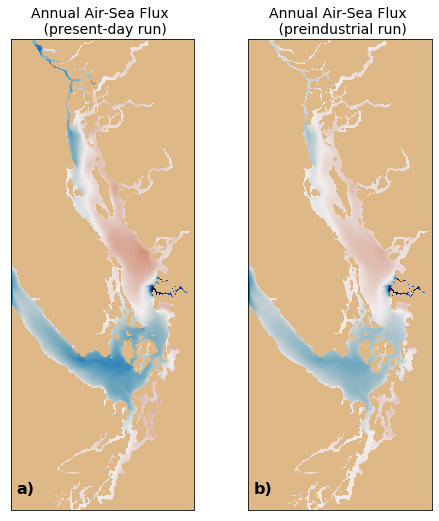

In [21]:
fs = 14
fact = 0.7
fig = plt.figure(figsize=(10*fact, 10.5*fact)) 

ax3 = plt.subplot2grid((1,2), (0,0), colspan=1,rowspan = 2)
tplt = BR_flx_gC_m2_yr
viz_tools.set_aspect(ax3)
mesh = ax3.pcolormesh(tplt, cmap=cm.balance, vmin=-120, vmax=120)
viz_tools.plot_land_mask(ax3, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax3.set_title('Annual Air-Sea Flux \n (present-day run)', fontsize = fs)
plt.xticks([])
plt.yticks([])
#cbar = plt.colorbar(mesh)
#cbar.ax.tick_params(labelsize=fs)
#cbar.set_label('g C $m^{-2}$$yr^{-1}$', fontsize = fs)
ax3.text(0.03, 0.03, 'a)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='bottom')


ax5 = plt.subplot2grid((1,2), (0,1), colspan=1,rowspan = 2)
tplt = PI_flx_gC_m2_yr
viz_tools.set_aspect(ax5)
mesh = ax5.pcolormesh(tplt, cmap=cm.balance, vmin=-120, vmax=120)
viz_tools.plot_land_mask(ax5, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax5.set_title('Annual Air-Sea Flux \n (preindustrial run)', fontsize = fs)
plt.xticks([])
plt.yticks([])
#cbar = plt.colorbar(mesh)
#cbar.ax.tick_params(labelsize=fs, rotation = 90)
#cbar.set_label('g C $m^{-2}$$yr^{-1}$', fontsize = fs)
ax5.text(0.03, 0.03, 'b)', transform=ax5.transAxes, fontsize=16, fontweight='bold', va='bottom')


plt.tight_layout()
plt.savefig('Fig3_ab.png')